<a href="https://colab.research.google.com/github/marketakvasova/LSEC_segmentation/blob/main/automatic_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automatic segmentation of electron microscope images**

# 1. Setup

In [13]:
!python --version
!pip install wandb

import os
from google.colab import drive
import torch.cuda
# from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
from torchsummary import summary
import shutil
import cv2 as cv
from numpy.lib.stride_tricks import as_strided
import pywt
from scipy.stats import norm
from google.colab.patches import cv2_imshow
import gc
import wandb
from numba import njit

# gc.collect()
drive.mount('/content/gdrive')
model_folder = "./gdrive/MyDrive/ROI_patches/my_model"
os.makedirs(model_folder, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # TODO: do not even try this, if the gpu is not connected
print(DEVICE)
biomodel_folder = os.path.join(model_folder, "bioimageio_model")
biomodel_path = os.path.join(biomodel_folder, "weights.pt")
os.makedirs(biomodel_folder, exist_ok=True)
LOAD_TRAINED_MODEL = False
model_path = os.path.join(model_folder,"my_checkpoint.pth.tar")

Python 3.10.12
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cuda


# Utils

## Data utils

In [26]:
class MyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transofrm=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transofrm
        self.images = sorted(os.listdir(self.image_dir)) # listdir returns arbitrary order
        self.masks = sorted(os.listdir(self.mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index]) # mask and image need to be called the same
        image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        mask[mask == 255.0] = 1
        return image, mask

class TransformDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, mask = self.dataset[index]
        augmentations = self.transform(image=image, mask=mask)
        image = augmentations["image"]
        mask = augmentations["mask"]
        return image, mask

    def __len__(self):
        return len(self.dataset)


def get_loaders(img_dir, mask_dir, split, batch_size, num_workers=4, pin_memory=True): # TODO: check these parameters
    data = MyDataset(
        image_dir=img_dir,
        mask_dir=mask_dir,
        transofrm=None
    )

    train_transform, val_transform = get_transforms()

    train_indices, test_indices = train_test_split(
        range(len(data)),
        test_size=split,
        random_state=42
    )
    train_data = TransformDataset(Subset(data, train_indices), train_transform)
    val_data = TransformDataset(Subset(data, test_indices), val_transform)

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True
    )

    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False
    )

    return train_loader, val_loader, train_indices

def get_transforms():
    train_transform = A.Compose( # TODO: background(preprocessing?), intensity
        [
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            # A.Affine(shear=(0.5,1)),
            # A.Affine(scale=(-10, 10)),
            A.Normalize(
                mean = 0.0,
                std = 1.0,
                max_pixel_value=255.0, # normalization to [0, 1]
            ),
            ToTensorV2()
        ]
    )

    val_transform = A.Compose(
        [
            A.Normalize(
                mean = 0.0,
                std = 1.0,
                max_pixel_value=255.0,
            ),
            ToTensorV2()
        ]
    )
    return train_transform, val_transform

# test_transform = A.Compose(
#     [
#     A.Normalize(
#       mean = 0.0,
#       std = 1.0,
#       max_pixel_value=255.0,
#     ),
#         ToTensorV2()
#     ]
# )

test_transform = transforms.Compose([
    transforms.ToTensor(),
    # Add more transformations if needed
])

def merge_images(image, mask):
    merge = np.zeros((mask.shape[0], mask.shape[1], 3))
    merge[:, :, 0] = image # B channel (0, 1, 2) = (B, G, R)
    merge[:, :, 2] = image # R channel
    merge[:, :, 1] = mask # G channel
    merge[:, :, 2][mask == 255.0] = 255 # R channel
    merge = merge.astype('uint8')
    return merge

def merge_original_mask(image_path, mask_path, output_folder):
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
    merge = merge_images(image, mask)
    filename_ext = os.path.basename(image_path)
    filename, ext = os.path.splitext(filename_ext)
    cv.imwrite(os.path.join(output_folder, filename+"_original_mask_merge"+".png"), merge)

def merge_masks(mask1_path, mask2_path, output_folder):
    mask1 = cv.imread(mask1_path, cv.IMREAD_GRAYSCALE)
    mask2 = cv.imread(mask2_path, cv.IMREAD_GRAYSCALE)
    # merge = merge_images(image, mask)
    merge = np.zeros((mask1.shape[0], mask1.shape[1], 3))

    merge[:, :, 1][mask1 == 255.0] = 255
    merge[:, :, 2][mask2 == 255.0] = 255

    filename_ext = os.path.basename(mask1_path)
    filename, ext = os.path.splitext(filename_ext)
    cv.imwrite(os.path.join(output_folder, filename+"_mask_compare"+".png"), merge)


def create_weighting_patches(patch_size, edge_size):
    patch = np.ones((patch_size, patch_size), dtype=float)

    # Calculate the linear decrease values
    decrease_values = np.linspace(1, 0, num=edge_size)
    decrease_values = np.tile(decrease_values, (patch_size, 1))
    increase_values = np.linspace(0, 1, num=edge_size)
    increase_values = np.tile(increase_values, (patch_size, 1))

    # Middle patch
    # Apply linear decrease to all four edges
    middle = patch.copy()
    middle[:, 0:edge_size] *= increase_values
    middle[:, patch_size-edge_size:patch_size] *= decrease_values
    middle[0:edge_size, :] *= increase_values.T
    middle[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((middle*255).astype(np.uint8))

    # Left
    left = patch.copy()
    left[:, patch_size-edge_size:patch_size] *= decrease_values
    left[0:edge_size, :] *= increase_values.T
    left[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((left*255).astype(np.uint8))

    # Right
    right = patch.copy()
    right[:, 0:edge_size] *= increase_values
    right[0:edge_size, :] *= increase_values.T
    right[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((right*255).astype(np.uint8))

    # Top
    top = patch.copy()
    top[:, 0:edge_size] *= increase_values
    top[:, patch_size-edge_size:patch_size] *= decrease_values
    top[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((top*255).astype(np.uint8))

    # Bottom
    bottom = patch.copy()
    bottom[:, 0:edge_size] *= increase_values
    bottom[:, patch_size-edge_size:patch_size] *= decrease_values
    bottom[0:edge_size, :] *= increase_values.T
    # cv2_imshow((bottom*255).astype(np.uint8))

    # Left Top edge
    top_left = patch.copy()
    top_left[:, patch_size-edge_size:patch_size] *= decrease_values
    top_left[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((top_left*255).astype(np.uint8))

    # Right top edge
    top_right = patch.copy()
    top_right[:, 0:edge_size] *= increase_values
    top_right[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((top_right*255).astype(np.uint8))

    # Left bottom edge
    bottom_left = patch.copy()
    bottom_left[:, patch_size-edge_size:patch_size] *= decrease_values
    bottom_left[0:edge_size, :] *= increase_values.T
    # cv2_imshow((bottom_left*255).astype(np.uint8))

    # Right Bottom edge
    bottom_right = patch.copy()
    bottom_right[:, 0:edge_size] *= increase_values
    bottom_right[0:edge_size, :] *= increase_values.T
    # cv2_imshow((bottom_right*255).astype(np.uint8))

    return middle, top_left, top, top_right, right, bottom_right, bottom, bottom_left, left

def inference_on_image_with_overlap(model, image_path, output_folder):
    window_size = 512
    oh, ow = 124, 124
    input_image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    image_height, image_width = input_image.shape
    original_height, original_width = image_height, image_width
    bottom_edge = image_height % (window_size - oh)
    right_edge = image_width % (window_size - ow)
    mirrored_image = np.zeros((image_height+bottom_edge, image_width+right_edge)).astype(np.uint8)
    mirrored_image[:image_height, :image_width] = input_image
    mirrored_image[image_height:, :image_width] = np.flipud(input_image[image_height-bottom_edge:, :])
    mirrored_image[:, image_width:] = np.fliplr(mirrored_image[:, image_width-right_edge:image_width])
    image_height += bottom_edge
    image_width += right_edge
    weights = np.zeros((image_height, image_width))
    # tryout = np.zeros((image_height, image_width))
    output_probs = np.zeros((image_height, image_width))
    output_mask = np.zeros((image_height, image_width))
    middle, top_left, top, top_right, right, bottom_right, bottom, bottom_left, left = create_weighting_patches(window_size, oh)

    for x in range(0, image_height-window_size+1, window_size - oh):
        for y in range(0, image_width-window_size+1, window_size - ow):
            # Choose weighting window
            if x == 0:
                if y == 0:
                    weighting_window = top_left
                elif y == window_size - ow - 1:
                    weighting_window = top_right
                else:
                    weighting_window = top
            elif x == window_size - oh - 1:
                if y == 0:
                    weighting_window = bottom_left
                elif y == window_size - ow - 1:
                    weighting_window = bottom_right
                else:
                    weighting_window = bottom
            elif y == 0:
                weighting_window = left
            elif y == window_size - ow - 1:
                weighting_window = right
            else:
                weighting_window = middle
            square_section = mirrored_image[x:x + window_size, y:y + window_size]
            weights[x:x + window_size, y:y + window_size] += 1
            # tryout[x:x + window_size, y:y + window_size] += np.ones((window_size, window_size))*weighting_window
            square_section = preprocess_image(square_section)
            square_tensor = test_transform(square_section).unsqueeze(0).to(DEVICE)  # Add batch dimension

            # Forward pass through the model
            with torch.no_grad():
                output = torch.sigmoid(model(square_tensor)).float()

            # Scale the probablity to 0-255
            output = output*255
            output = output.to(torch.uint8)
            output_pil = output.squeeze(0).cpu().numpy()
            output_probs[x:x+window_size, y:y+window_size] += output_pil.squeeze()*weighting_window
    # Crop
    output_probs = output_probs[:original_height, :original_width]
    weights = weights[:original_height, :original_width]
    # tryout = tryout[:original_height, :original_width]*255

    # Apply weights
    # output_probs /= weights

    # Create image from mask
    output_mask = np.where(output_probs > 127, 255, 0)
    output_mask = output_mask.astype(np.uint8)
    filename_ext = os.path.basename(image_path)
    filename, ext = os.path.splitext(filename_ext)

    # Merge image with created mask
    out_mask_path = os.path.join(output_folder, filename+"_mask"+".png")
    merge = merge_images(input_image, output_mask)
    cv.imwrite(os.path.join(output_folder, filename+"_merge"+".png"), merge)

    cv.imwrite(os.path.join(output_folder, filename+"_probs"+".png"), output_probs)
    cv.imwrite(out_mask_path, output_mask)
    # cv.imwrite(os.path.join(output_folder, filename+"_tryout"+".png"), tryout)
    return out_mask_path

def preprocess_image(image):

    # image = wavelet_denoise(image)
    image = apply_clahe(image)
    image = cv.medianBlur(image, 5)

    return image

def apply_clahe(image):
    clahe = cv.createCLAHE(clipLimit=0.8, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image


def create_image_patches(image_folder, mask_folder, output_folder, patch_size):
    image_patches_path = os.path.join(output_folder,'image_patches')
    mask_patches_path = os.path.join(output_folder,'mask_patches')
    # rejected_path = os.path.join(output_folder,'rejected')
    # print(image_path)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    if os.path.exists(image_patches_path):
        shutil.rmtree(image_patches_path)
    os.mkdir(image_patches_path)
    if os.path.exists(mask_patches_path):
        shutil.rmtree(mask_patches_path)
    os.mkdir(mask_patches_path)
    # if os.path.exists(rejected_path):
    #     shutil.rmtree(rejected_path)
    # os.mkdir(rejected_path)

    patch_area = patch_size**2
    fenestration_area_thresh = 0.05
    image_filenames = sorted(os.listdir(image_folder))
    mask_filenames = sorted(os.listdir(mask_folder))

    for image_name, mask_name in zip(image_filenames, mask_filenames):
        if image_name.endswith(".tif"):
            input_path = os.path.join(image_folder, image_name)
            mask_path = os.path.join(mask_folder, mask_name)

            img = cv.imread(input_path, cv.IMREAD_GRAYSCALE)
            mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
            height, width = img.shape

            shape = (height // patch_size, width // patch_size, patch_size, patch_size)
            strides = (patch_size * width , patch_size , width, 1)
            # strides = (patch_size * width , patch_size)

            # img_strided = as_strided(img, shape=(width//patch_size, height//patch_size, patch_size, patch_size),
            #              strides=img.strides + img.strides, writeable=False)
            img_strided = as_strided(img, shape=shape,
                          strides=strides, writeable=False) #TODO: check if the patches do not overlap
            mask_strided = as_strided(mask, shape=shape,
                          strides=strides, writeable=False)

            for i in range(img_strided.shape[0]):
                for j in range(img_strided.shape[1]):
                    img_patch = img_strided[i, j]
                    mask_patch = mask_strided[i, j]
                    # Compute the percentage of white pixels
                    fenestration_area = np.sum(mask_patch == 255)
                    fenestration_percentage = fenestration_area/patch_area
                    if fenestration_area > fenestration_area_thresh:
                        patch_filename = f"{os.path.splitext(os.path.basename(image_name))[0]}_patch_{i}_{j}.tif"
                        # preprocess image
                        img_patch = preprocess_image(img_patch)
                        cv.imwrite(os.path.join(image_patches_path, patch_filename), img_patch)
                        cv.imwrite(os.path.join(mask_patches_path, patch_filename), mask_patch)
                        # print("written patch ", patch_filename)
                    else:
                        print("not writing patch")
    return image_patches_path, mask_patches_path

# Denoising


def anscombe_transform(data):
    return 2 * np.sqrt(data + 3/8)

def inverse_anscombe_transform(data):
    data = (data / 2)**2 - 3/8
    return data.astype(np.uint8)

# from skimage.restoration import (denoise_wavelet, estimate_sigma)
# def wavelet_denoising(data, wavelet='db1', level=1, threshold_type='soft', sigma=None):
#     sigma_est = estimate_sigma(data)*0.009 # This should be very small, black pixels otherwise
#     print(sigma_est)
#     denoised = denoise_wavelet(data, method='BayesShrink', mode='soft', rescale_sigma=True)
#     # method: BayesShrihk/VisuShrink
#     return denoised


def wavelet_denoising(data, wavelet='db1', level=1, threshold_type='soft', sigma=None):
    coeffs = pywt.wavedec2(data, wavelet, level=level)
    # threshold = sigma * np.sqrt(2 * np.log(len(data))) if sigma is not None else None
    # print(len(coeffs))
    # for i in range(len(coeffs)):
    #     coeffs[i] = pywt.threshold(coeffs[i], threshold, threshold_type)

    threshold = 0.03
    for i in range(1, len(coeffs)):
        threshold_value = threshold * np.nanmean(np.abs(coeffs[i]))
        # print(threshold_value)
        coeffs[i] = tuple(pywt.threshold(c, threshold_value, threshold_type) for c in coeffs[i])

    return pywt.waverec2(coeffs, wavelet)

def wavelet_denoise(image):
    image = anscombe_transform(image)
    image = wavelet_denoising(image, wavelet = 'db1', level=3, threshold_type='soft', sigma=1)
    image = inverse_anscombe_transform(image)
    return image

## Training utils

In [15]:
def save_checkpoint(model, model_path):#, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    model.save(model_path)
    # torch.save(state, filename)

def save_state_dict(model, model_path):
    print("=> Saving checkpoint")
    torch.save(model.state_dict(), model_path)

def load_state_dict(model, model_path):
    print("=> Loading checkpoint")
    model.load_state_dict(torch.load(model_path))

def validate_model(model, loader, loss_fn):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.float().to(DEVICE).unsqueeze(1)
            # Forward
            preds = torch.sigmoid(model(x)) # TODO: vystupy modelu bez sigmoidy jsou zaporny hodnoty
            # loss_fn = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(16))
            loss = loss_fn(preds, y)
            running_loss += loss.cpu()
            preds = (preds > 0.5).float()

            # num_correct += (preds == y).sum()
            # num_pixels += torch.numel(preds)
            dice_score += (2*(preds*y).sum()) / (preds+y).sum() + 1e-8 # this is a better predictor
    # print(
    #     f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f} ()"
    # )
    dice_score = dice_score/len(loader)
    val_loss = running_loss/len(loader) #TODO: not sure this is correct(dividing by batch size?)
    # print(f"Dice score is {dice_score}")
    # val_losses.append(running_loss/len(loader))
    # dice_scores.append(dice_score.cpu())
    model.train()
    return val_loss, dice_score.cpu()

def check_accuracy(loader, model, val_losses, dice_scores, device, loss_fn):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).float().unsqueeze(1)
            # preds = torch.softmax(model(x), dim=1)
            preds = torch.sigmoid(model(x)) # TODO: vystupy modelu bez sigmoidy jsou zaporny hodnoty
            loss = loss_fn(preds, y)
            running_loss += loss.cpu()
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2*(preds*y).sum()) / (preds+y).sum() + 1e-8 # this is a better predictor
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f} ()"
    )
    dice_score = dice_score/len(loader)
    print(f"Dice score is {dice_score}")
    val_losses.append(running_loss/len(loader))
    dice_scores.append(dice_score.cpu())
    model.train()
    return dice_score

# def save_predictions_as_imgs(
#         loader, model, folder="saved_images", device="cpu"
# ):
#     model.eval()
#     for idx, (x, y) in enumerate(loader):
#         x = x.to(device=device)
#         with torch.no_grad():
#             preds = torch.sigmoid(model(x))
#             preds = (preds > 0.5).float()
#         # print(f"preds max{preds.max()}")
#         # print(f"y max {y.max()}")
#         # torchvision.utils.save_image(preds, os.path.join(folder, f"pred{idx}.png"))
#         # torchvision.utils.save_image(y.unsqueeze(1), os.path.join(folder, f"pred{idx}_correct.png"))
#             imshow(preds)
#             imshow(y.unsqueeze(1))
#         break # TODO: change this so it does not loop
#     model.train()
#     print("Saving prediction as images.")

def view_prediction(loader, model, device="cpu"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            # output = torch.softmax(model(x), dim=1)
            output = torch.sigmoid(model(x))
            preds = (output > 0.5).float()
            preds = preds.cpu().data.numpy()
            output = output.cpu().data.numpy()
            for i in range(preds.shape[0]):
                f=plt.figure(figsize=(128,32))
                # Original image
                plt.subplot(1,5*preds.shape[0],i+1)
                x = x.cpu()
                plt.imshow(x[i, 0, :, :], cmap='gray') # preds is a batch
                plt.title('Validation image')
                # NN output(probability)
                plt.subplot(1,5*preds.shape[0],i+2)
                plt.imshow(output[i, 0, :, :], interpolation='nearest', cmap='magma') # preds is a batch
                plt.title('NN output')
                # Segmentation
                plt.subplot(1,5*preds.shape[0],i+3)
                plt.imshow(preds[i, 0, :, :], cmap='gray') # preds is a batch
                plt.title('Prediction')
                # True mask
                plt.subplot(1,5*preds.shape[0],i+4)
                plt.imshow(y.unsqueeze(1)[i, 0, :, :], cmap='gray')
                plt.title('Ground truth')
                # IoU
                plt.subplot(1,5*preds.shape[0],i+5)
                im1 = y.unsqueeze(1)[i, 0, :, :]
                im2 = preds[i, 0, :, :]
                plt.imshow(im1, alpha=0.8, cmap='Blues')
                plt.imshow(im2, alpha=0.6,cmap='Oranges')
                plt.title('IoU')

            plt.show()
            break # TODO: change this so it does not loop
    model.train()


def getClassWeights(mask_path, train_indices):
    mask_dir_list = sorted(os.listdir(mask_path))
    class_count = np.zeros(2, dtype=int)
    for i in train_indices:
        mask = cv.imread(os.path.join(mask_path, mask_dir_list[i]), cv.IMREAD_GRAYSCALE) #np.array(Image.open(os.path.join(mask_path, mask_dir_list[i])).convert('L'), dtype=np.float32)
        mask[mask == 255.0] = 1
        class_count[0] += mask.shape[0]*mask.shape[1] - mask.sum()
        class_count[1] += mask.sum()

    n_samples = class_count.sum()
    n_classes = 2

    class_weights = n_samples / (n_classes * class_count)
    return torch.from_numpy(class_weights)


## Debug

10.060989226918716
Number of fenestrations: 8317
Number of fitted ellipses: 8312


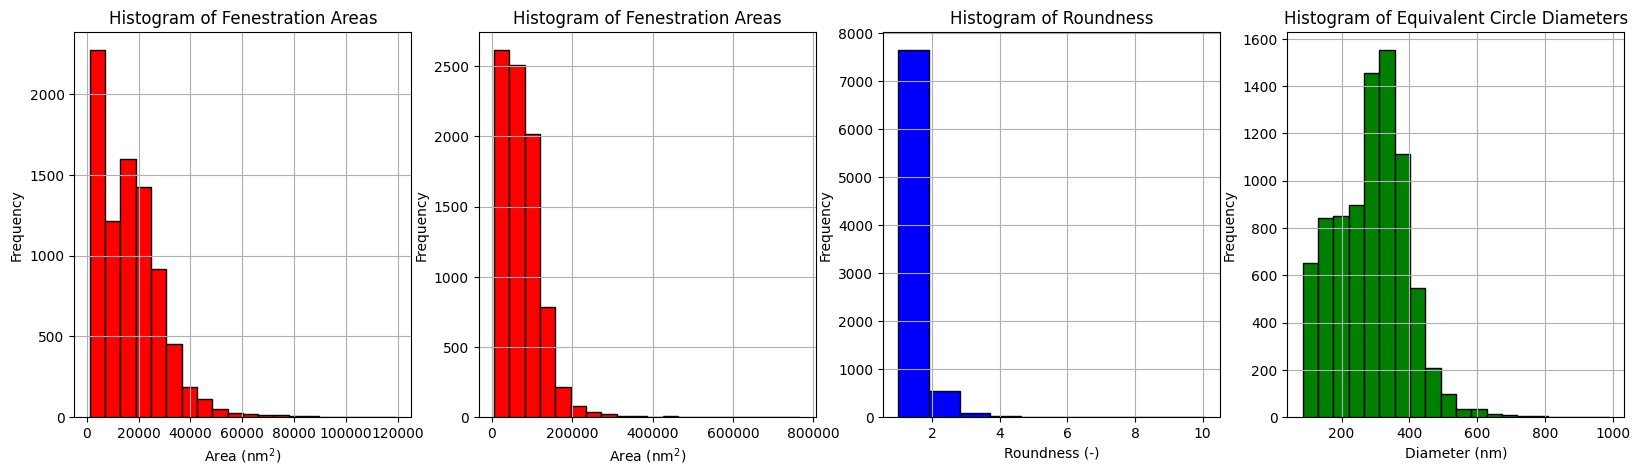

In [4]:
import cv2
import numpy as np
import math

def show_fitted_ellipses(image_path, ellipses):
    image = cv2.imread(image_path)
    for ellipse in ellipses:
        cv2.ellipse(image, ellipse, (0, 0, 255), 1)
        center, axes, angle = ellipse
        center_x, center_y = center
        major_axis_length, minor_axis_length = axes
        rotation_angle = angle
        # print(center_x, center_y)
        cv2.circle(image, (int(center_x), int(center_y)),radius=1, color=(0, 0, 255), thickness=-1)

        # print("Center:", center)
        # print("Major Axis Length:", major_axis_length)
        # print("Minor Axis Length:", minor_axis_length)
        # print("Rotation Angle:", rotation_angle)

    cv2_imshow(image)

def fit_ellipses(filtered_contours, centers):
    ellipses = []
    for contour, cnt_center in zip(filtered_contours, centers):
        if len(contour) >= 5:  # Ellipse fitting requires at least 5 points
            ellipse = cv2.fitEllipse(contour) # TODO: maybe try a different computation, if this does not work well
            # ellipse = cv2.minAreaRect(cnt) # the fitEllipse functions fails sometimes(when the fenestration is on the edge and only a part of it is visible)
            dist = cv2.norm(cnt_center, ellipse[0])
            # print(dist)
            if dist < 20:
                ellipses.append(ellipse)
    return ellipses

def find_fenestration_contours(image_path):
    seg_mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(seg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # image = cv2.cvtColor(seg_mask, cv2.COLOR_GRAY2RGB)
    # image_el = image.copy()
    # cv2.drawContours(image, contours, -1, (0, 0, 255), 1)
    # cv2_imshow(image)

    # Remove noise and small artifacts
    min_contour_area = 10
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    return filtered_contours

def find_contour_centers(contours):
    contour_centers = []
    for cnt in contours:
        M = cv2.moments(cnt)
        center_x = int(M['m10'] / M['m00'])
        center_y = int(M['m01'] / M['m00'])
        contour_centers.append((center_x, center_y))
    return contour_centers

def equivalent_circle_diameter(major_axis_length, minor_axis_length):
    return math.sqrt(4 * major_axis_length * minor_axis_length)

def show_statistics(fenestration_areas, fenestration_areas_from_ellipses, roundness_of_ellipses, equivalent_diameters):
    plt.figure(figsize=(20, 5))

    # Plot histogram of fenestration areas
    plt.subplot(1, 4, 1)
    plt.hist(fenestration_areas, bins=20, color='red', edgecolor='black')
    plt.title('Histogram of Fenestration Areas')
    plt.xlabel('Area ($\mathrm{nm}^2$)')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Plot histogram of areas of fitted elipses
    plt.subplot(1, 4, 2)
    plt.hist(fenestration_areas_from_ellipses, bins=20, color='red', edgecolor='black')
    plt.title('Histogram of Fenestration Areas')
    plt.xlabel('Area ($\mathrm{nm}^2$)')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Plot histogram of roundness
    plt.subplot(1, 4, 3)
    plt.hist(roundness_of_ellipses, bins=10, color='blue', edgecolor='black')
    plt.title('Histogram of Roundness')
    plt.xlabel('Roundness (-)')
    plt.ylabel('Frequency')
    plt.grid(True)
    print(np.array(roundness_of_ellipses).max())

    # Plot histogram of equivalent circle diameters
    plt.subplot(1, 4, 4)
    plt.hist(equivalent_diameters, bins=20, color='green', edgecolor='black')
    plt.title('Histogram of Equivalent Circle Diameters')
    plt.xlabel('Diameter (nm)')
    plt.ylabel('Frequency')
    plt.grid(True)



# Mask statistics debug
# One pixel corresponds to 10.62 nm
image_path = "./gdrive/MyDrive/ROIs_manually_corrected/augment_mask/_0_379.tif"
image_path = "./gdrive/MyDrive/lsec_test/old11_CA150_NE_01_original_mask.tif" # Image from semiautomatic labeling


pixel_size_nm = 10.62
contours = find_fenestration_contours(image_path)
fenestration_areas = [cv2.contourArea(cnt) * (pixel_size_nm**2) for cnt in contours]
contour_centers = find_contour_centers(contours)
ellipses = fit_ellipses(contours, contour_centers)

# Show image of fitted ellipses
# show_fitted_ellipses(image_path, ellipses)

roundness_of_ellipses = []
equivalent_diameters = []
fenestration_areas_from_ellipses = []

for ellipse in ellipses:
    center, axes, angle = ellipse
    # center_x, center_y = center
    major_axis_length, minor_axis_length = axes
    roundness = minor_axis_length/major_axis_length
    roundness_of_ellipses.append(roundness)
    # rotation_angle = angle
    diameter = pixel_size_nm * equivalent_circle_diameter(major_axis_length, minor_axis_length)
    equivalent_diameters.append(diameter)
    fenestration_areas_from_ellipses.append((diameter**2)/4*math.pi)

show_statistics(fenestration_areas, fenestration_areas_from_ellipses, roundness_of_ellipses, equivalent_diameters)


# Display the number of circles and their fitted ellipses
print("Number of fenestrations:", len(contours))
print("Number of fitted ellipses:", len(ellipses))

In [ ]:
# # Wavelet filtering debug

image_folder = "./gdrive/MyDrive/ROIs_manually_corrected/train_images"
images = os.listdir(image_folder)
image_name = images[0]
image = cv.imread(os.path.join(image_folder, image_name), cv.IMREAD_GRAYSCALE)
# cv2_imshow(image)

denoised_image = wavelet_denoise(image)
# cv2_imshow(denoised_image)



# U-Net definition

In [16]:
# import torchvision.transforms.functional as TF


def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )
    return conv

#def cropper(og_tensor, target_tensor):
#    og_shape = og_tensor.shape[2]
#    target_shape = target_tensor.shape[2]
#    delta = (og_shape - target_shape) // 2
#    cropped_og_tensor = og_tensor[:,:,delta:og_shape-delta,delta:og_shape-delta]
#    return cropped_og_tensor


def padder(left_tensor, right_tensor, device: str):
  # left_tensor is the tensor on the encoder side of UNET
  # right_tensor is the tensor on the decoder side  of the UNET

    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(device)

    return right_tensor.to(device)



class UNET(nn.Module):
    def __init__(self, in_channels, out_channels, device, dropout_probability):
        super(UNET, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.device = device
        self.dropout = nn.Dropout(p=dropout_probability)

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.down_conv_1 = double_conv(in_ch=self.in_channels,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        #print(self.down_conv_1)

        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)

        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)

        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.out_channels,kernel_size=1,stride=1)

    def forward(self, x):
        # x = x.to(self.device)
        x1 = self.down_conv_1(x)
        p1 = self.max_pool(x1)
        x2 = self.down_conv_2(p1)
        p2 = self.max_pool(x2)
        p2 = self.dropout(p2)
        x3 = self.down_conv_3(p2)
        p3 = self.max_pool(x3)
        p3 = self.dropout(p3)
        x4 = self.down_conv_4(p3)
        p4 = self.max_pool(x4)
        p4 = self.dropout(p4)
        x5 = self.down_conv_5(p4)

        # decoding
        d1 = self.up_conv_trans_1(x5)  # up transpose convolution ("up sampling" as called in UNET paper)
        pad1 = padder(x4,d1, self.device) # padding d1 to match x4 shape
        cat1 = torch.cat([x4,pad1],dim=1) # concatenating padded d1 and x4 on channel dimension(dim 1) [batch(dim 0),channel(dim 1),height(dim 2),width(dim 3)]
        cat1 = self.dropout(cat1)
        uc1 = self.up_conv_1(cat1) # 1st up double convolution

        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2, self.device)
        cat2 = torch.cat([x3,pad2],dim=1)
        cat2 = self.dropout(cat2)
        uc2 = self.up_conv_2(cat2)

        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3, self.device)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)

        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4, self.device)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)

        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1

# Training function definition

In [ ]:
# def train_fn(loader, model, optimizer, loss_fn, scaler):
#     loop = tqdm(loader)
#     running_loss = 0
#     # model.train()
#     for batch_idx, (data, targets) in enumerate(loop):
#         data = data.to(device=DEVICE)
#         targets = targets.float().unsqueeze(1).to(device=DEVICE)

#     # forward
#         with torch.cuda.amp.autocast():
#             predictions = model(data) # TODO: shoud this be wrapped in sigmoid???
#             loss = loss_fn(torch.sigmoid(predictions), targets)

#         # backward
#         optimizer.zero_grad() # Zero the gradients

#         # loss.backward()
#         # optimizer.step()
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
#         running_loss += loss.item()

#         # update tqdm loop
#         loop.set_postfix(loss = loss.item())
#         # print(batch_idx)
#     number_of_batches = batch_idx+1
#     # train_losses.append(running_loss/number_of_batches)

#Patch creation

In [17]:
CREATE_NEW_PATCHES = False
SAVE_PATCHES_TO_DISK = False
# CREATE_NEW_PATCHES = True
# SAVE_PATCHES_TO_DISK = True
# Example usage:

image_folder = "./gdrive/MyDrive/ROIs_manually_corrected/train_images"
mask_folder = "./gdrive/MyDrive/ROIs_manually_corrected/train_masks"

if CREATE_NEW_PATCHES:
    patch_size = 512  # Define your patch size here
    if SAVE_PATCHES_TO_DISK:
        output_folder = "./gdrive/MyDrive/ROIs_manually_corrected/patches"
    else:
        output_folder = os.getcwd()
    image_patches_path, mask_patches_path = create_image_patches(image_folder, mask_folder, output_folder, patch_size)
else: # The patches will be read from disk
    output_folder = "./gdrive/MyDrive/ROIs_manually_corrected/patches"
    image_patches_path = os.path.join(output_folder, 'image_patches')
    mask_patches_path = os.path.join(output_folder, 'mask_patches')


# Training setup

In [32]:
# Training parameters
learning_rate = 1e-4
batch_size = 4
num_epochs = 2
num_workers = 0
pin_memory = False # TODO: check
load_model = False

# Define dataloaders for training
data_split = 0.1

# Train and test images, these don't crash the gpu
# image_patches_path = "./gdrive/MyDrive/ROI_patches/train_img"
# mask_patches_path = "./gdrive/MyDrive/ROI_patches/train_mask"


train_loader, val_loader, train_indices = get_loaders(
    image_patches_path,
    mask_patches_path,
    data_split,
    batch_size,
    num_workers,
    pin_memory
)

model = UNET(in_channels=1, out_channels=1, device=DEVICE, dropout_probability=0.5).to(DEVICE)


FileNotFoundError: [Errno 2] No such file or directory: './gdrive/MyDrive/ROIs_manually_corrected/patches/image_patches'

# Wandb sweep

In [6]:
def build_optimizer(model, config, beta1=None, beta2=None):
    if config.optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=config.learning_rate,
                              weight_decay=config.weight_decay,
                              momentum=config.momentum)
    elif config.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(),
                               lr=config.learning_rate,
                               betas=(config.beta1, config.beta2),
                               weight_decay=config.weight_decay)
    return optimizer

# TRAIN_LOADER = train_loader
# VAL_LOADER = val_loader
def build_dataloaders(config): # TODO: check if there is a better way to do this
    image_patches_path = os.path.join(config.image_patches_path, 'patches_'+ config.image_denoising_methods)
    mask_patches_path = os.path.join(config.mask_patches_path, 'patches_'+ config.image_denoising_methods)
    image_patches_path = os.path.join(image_patches_path, 'image_patches')
    mask_patches_path = os.path.join(mask_patches_path, 'mask_patches')
    train_loader, val_loader, _ = get_loaders(
        image_patches_path,
        mask_patches_path,
        config.data_split,
        config.batch_size,
        num_workers=0,
        pin_memory=False
    )
    return train_loader, val_loader # this is the simplest way to do it, wandb train cannot take any arguments

def train_epoch(model, train_loader, optimizer, loss_fn):
    # model.train()
    running_loss = 0
    scaler = torch.cuda.amp.GradScaler()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data) # TODO: shoud this be thresholded???
            # TODO: change this
            # loss = F.nll_loss(torch.sigmoid(predictions), targets)
            # loss_fn = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(16))
            loss = loss_fn(torch.sigmoid(predictions), targets)
            # loss = loss_fn(torch.sigmoid(predictions), targets)

        # backward
        optimizer.zero_grad() # Zero the gradients
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        if WANDB_CONNECTED or WANDB_LOG:
            wandb.log({"batch loss": loss.item()})

    number_of_batches = batch_idx+1
    return running_loss/number_of_batches

def build_model(dropout):
    return UNET(in_channels=1, out_channels=1, device=DEVICE, dropout_probability=dropout).to(DEVICE)

def wandb_train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        config = wandb.config

        train_loader, val_loader = build_dataloaders(config)
        model = build_model(config.dropout)
        optimizer = build_optimizer(model, config)
        loss_fn = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(4))

        for epoch in range(config.epochs):
            avg_loss = train_epoch(model, train_loader, optimizer, loss_fn)
            # print(avg_loss)
            metrics = {"train/loss": avg_loss, "train/epoch": epoch}
            val_loss, dice_score = validate_model(model, val_loader, loss_fn)
            val_metrics = {"val/val_loss": val_loss,
                           "val/dice_score": dice_score}
            wandb.log({**metrics, **val_metrics})

class DictObject:
    def __init__(self, **entries):
        self.__dict__.update(entries)

def train(config, model_out_path):
    if WANDB_LOG:
        wandb.init(
            project="LSEC_segmentation",
            config=config)
        config = wandb.config
    else:
        config = DictObject(**config)

    train_loader, val_loader = build_dataloaders(config)
    model = build_model(config.dropout)
    optimizer = build_optimizer(model, config)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(4))

    best_dice_score = 0
    train_losses = []
    val_losses = []
    dice_scores = []

    for epoch in range(config.num_epochs):
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn)
        train_losses.append(train_loss)
        val_loss, dice_score = validate_model(model, val_loader, loss_fn)

        if dice_score > best_dice_score: # using dice score right now
            save_state_dict(model, model_out_path)
        best_dice_score = max(dice_score, best_dice_score)

        dice_scores.append(dice_score)
        val_losses.append(val_loss)
        print(f'Dice score: {dice_score}')
        view_prediction(val_loader, model, device = DEVICE)
        if WANDB_LOG:
            wandb.log({"train/train_loss": train_loss,
                       "train/epoch": epoch,
                       "val/val_loss": val_loss,
                       "val/dice_score":dice_score,
                       })
    if WANDB_LOG:
        wandb.finish()

    return train_losses, val_losses, dice_scores

In [8]:
output_folder = "./gdrive/MyDrive/ROIs_manually_corrected"
data_split = 0.1

# wandb sweep config
sweep_config = {
    'method': 'grid'#'bayes'
    }
metric = {
    'name': 'val/dice_score',
    'goal': 'maximize'
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        # 'values': ['adam', 'sgd']
        'value': 'sgd'
        },
    'learning_rate': {
        'value': 0.0186,
        # # a flat distribution between min and max
        # 'distribution': 'uniform',
        # 'min': 0.01,
        # 'max': 0.02
      },
    'weight_decay': {
        'value': 0.0189,
        # 'distribution': 'uniform',
        # 'min': 0.01,
        # 'max' : 0.02,
    },
    # sgd parameters
    'momentum':{
        'value': 0.0722,
        # 'distribution': 'uniform',
        # 'min': 0.06,
        # 'max' : 0.08,
    },

    'dropout': {
        'value': 0.0,
        #   'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
        },
    'epochs': {
        'value': 15
        },

    # Dataloader params
    'image_patches_path': {
        'value': output_folder
        },
    'mask_patches_path': {
        'value': output_folder
        },
    'data_split': {
        'value': data_split
        },
    'batch_size': {
        'value': 6,
        # # integers between min and max
        # # with evenly-distributed logarithms
        # 'distribution': 'q_log_uniform_values',
        # 'q': 2, # the discrete step of the distribution
        # 'min': 4,
        # 'max': 8,
      },
    # Adam parameters
    # 'beta1': {
    #     'distribution': 'uniform',
    #     'min': 0.95,
    #     'max' : 0.999,
    # },
    # 'beta2': {
    #     'distribution': 'uniform',
    #     'min': 0.95,
    #     'max' : 0.999,
    # },
        # 'fc_layer_size': {
    #     'values': [128, 256, 512]
    #     },
    'image_denoising_methods': {
        'values': ['clahe+median5', 'median3', 'median3+clahe', 'median5', 'median5+clahe', 'no_preprocess'],#['wavelet', 'wavelet+median', 'advanced median'] # k waveletu jeste pridat ruzne thresholdy
    },
}

sweep_config['parameters'] = parameters_dict
sweep_id = wandb.sweep(sweep_config, project="LSEC_segmentation")

Create sweep with ID: rvms628c
Sweep URL: https://wandb.ai/dpd/LSEC_segmentation/sweeps/rvms628c


In [9]:
WANDB_CONNECTED = True
wandb.agent(sweep_id, wandb_train, count=10)

wandb: Agent Starting Run: 5ce7mon0 with config:
wandb: 	batch_size: 6
wandb: 	data_split: 0.1
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	image_denoising_methods: clahe+median5
wandb: 	image_patches_path: ./gdrive/MyDrive/ROIs_manually_corrected
wandb: 	learning_rate: 0.0186
wandb: 	mask_patches_path: ./gdrive/MyDrive/ROIs_manually_corrected
wandb: 	momentum: 0.0722
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0189
wandb: Currently logged in as: marketakvasova1 (dpd). Use `wandb login --relogin` to force relogin


batch loss,█▇▇▆▅▅▄▄▃▃▃▃▃▂▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▂▂▁
train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁
val/dice_score,▁▄▆▆▆▇▇▇▇▇▇▇▇██
val/val_loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁
batch loss,0.81604
train/epoch,14
train/loss,0.78107
val/dice_score,0.63922
val/val_loss,0.77952


wandb: Agent Starting Run: frw24cx7 with config:
wandb: 	batch_size: 6
wandb: 	data_split: 0.1
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	image_denoising_methods: median3
wandb: 	image_patches_path: ./gdrive/MyDrive/ROIs_manually_corrected
wandb: 	learning_rate: 0.0186
wandb: 	mask_patches_path: ./gdrive/MyDrive/ROIs_manually_corrected
wandb: 	momentum: 0.0722
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0189


batch loss,██▆▅▅▅▄▄▅▄▄▄▃▃▃▂▃▃▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁
train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁
val/dice_score,▁▄▆▆▇▇▇▇▇▇▇▇███
val/val_loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁
batch loss,0.7708
train/epoch,14
train/loss,0.77865
val/dice_score,0.6299
val/val_loss,0.77886


wandb: Agent Starting Run: 6zyc6lhw with config:
wandb: 	batch_size: 6
wandb: 	data_split: 0.1
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	image_denoising_methods: median3+clahe
wandb: 	image_patches_path: ./gdrive/MyDrive/ROIs_manually_corrected
wandb: 	learning_rate: 0.0186
wandb: 	mask_patches_path: ./gdrive/MyDrive/ROIs_manually_corrected
wandb: 	momentum: 0.0722
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0189


batch loss,█▆▆▅▄▅▅▅▄▄▃▃▂▂▂▃▂▂▂▂▂▄▂▂▂▂▂▂▂▃▁▂▂▂▁▂▂▂▂▁
train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁
val/dice_score,▁▄▆▆▇▇▇▇▇▇▇▇███
val/val_loss,█▅▅▄▃▃▃▂▂▂▂▁▁▁▁
batch loss,0.78269
train/epoch,14
train/loss,0.7816
val/dice_score,0.61457
val/val_loss,0.7833


wandb: Agent Starting Run: fum1gijy with config:
wandb: 	batch_size: 6
wandb: 	data_split: 0.1
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	image_denoising_methods: median5
wandb: 	image_patches_path: ./gdrive/MyDrive/ROIs_manually_corrected
wandb: 	learning_rate: 0.0186
wandb: 	mask_patches_path: ./gdrive/MyDrive/ROIs_manually_corrected
wandb: 	momentum: 0.0722
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0189


batch loss,█▆▆▅▄▄▄▄▄▃▃▃▃▂▂▂▃▂▂▃▂▂▂▁▂▂▁▁▂▂▂▁▂▂▂▂▁▁▂▁
train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁
val/dice_score,▁▂▆▆▆▆▆▆▇▇▇▇▇██
val/val_loss,█▅▅▄▃▃▂▂▂▂▁▁▁▁▁
batch loss,0.77024
train/epoch,14
train/loss,0.77803
val/dice_score,0.64381
val/val_loss,0.7791


wandb: Agent Starting Run: vtu8bean with config:
wandb: 	batch_size: 6
wandb: 	data_split: 0.1
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	image_denoising_methods: median5+clahe
wandb: 	image_patches_path: ./gdrive/MyDrive/ROIs_manually_corrected
wandb: 	learning_rate: 0.0186
wandb: 	mask_patches_path: ./gdrive/MyDrive/ROIs_manually_corrected
wandb: 	momentum: 0.0722
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0189


batch loss,█▇▆▅▅▅▄▄▄▃▃▃▄▃▃▂▃▃▂▂▂▃▂▂▁▁▂▂▂▂▁▂▁▁▂▁▂▁▂▁
train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁
val/dice_score,▁▃▆▆▇▇▇▇▇▇▇▇███
val/val_loss,█▅▄▄▃▂▂▂▂▂▁▁▁▁▁
batch loss,0.77015
train/epoch,14
train/loss,0.77882
val/dice_score,0.63993
val/val_loss,0.77793


wandb: Agent Starting Run: 4myvtvjp with config:
wandb: 	batch_size: 6
wandb: 	data_split: 0.1
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	image_denoising_methods: no_preprocess
wandb: 	image_patches_path: ./gdrive/MyDrive/ROIs_manually_corrected
wandb: 	learning_rate: 0.0186
wandb: 	mask_patches_path: ./gdrive/MyDrive/ROIs_manually_corrected
wandb: 	momentum: 0.0722
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0189


batch loss,█▆▇▇▆▄▄▄▃▄▃▃▃▂▃▃▂▂▃▁▃▁▂▂▂▂▂▂▂▂▁▁▂▂▁▃▂▂▂▁
train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁
val/dice_score,▁▁▄▄▅▅▆▆▆▇▇▇███
val/val_loss,█▅▅▄▄▄▃▃▂▂▂▁▁▁▁
batch loss,0.7967
train/epoch,14
train/loss,0.7899
val/dice_score,0.51383
val/val_loss,0.79703


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# Training

In [18]:
LOAD_MODEL = False
WANDB_CONNECTED = False

config = {
    'batch_size' : 6,
    'dropout' : 0.0,
    'optimizer' : 'sgd',
    'num_epochs' : 50,
    'learning_rate' : 0.0186,
    'weight_decay' : 0.0189,
    'momentum' : 0.0722,
    'data_split' : 0.1,
    'image_patches_path': image_patches_path,
    'mask_patches_path': mask_patches_path,
}


In [ ]:
if LOAD_MODEL:
    model = UNET(in_channels=1, out_channels=1, device=DEVICE, dropout_probability=config['dropout']).to(DEVICE)
    load_state_dict(model, model_path)
else:
    WANDB_LOG = True
    train_losses, val_losses, dice_scores = train(config, model_path)

# Training evaluation

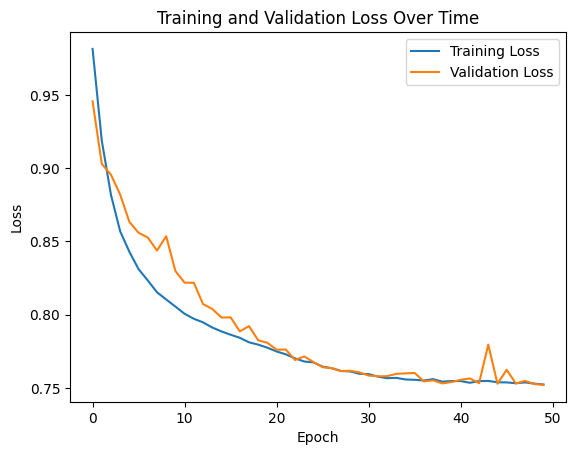

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

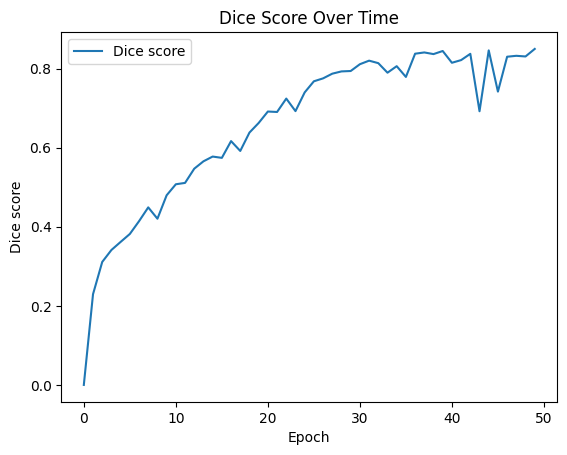

In [ ]:
plt.plot(dice_scores, label='Dice score')
plt.xlabel('Epoch')
plt.ylabel('Dice score')
plt.title('Dice Score Over Time')
plt.legend()
plt.show()

# Inference

In [27]:
# Inference on full images
test_image_path = "./gdrive/MyDrive/lsec_test/old11_CA150_NE_01.tif"
test_mask_path = "./gdrive/MyDrive/lsec_test/old11_CA150_NE_01_original_mask.tif"

output_folder = "./gdrive/MyDrive/lsec_test"
model = UNET(in_channels=1, out_channels=1, device=DEVICE, dropout_probability=config['dropout']).to(DEVICE)
model.load_state_dict(torch.load(model_path))
out_mask_path = inference_on_image_with_overlap(model, test_image_path, output_folder)
merge_original_mask(test_image_path, test_mask_path, output_folder)
merge_masks(out_mask_path, test_mask_path, output_folder)

# Bioimageio stuff

In [ ]:
# !pip install "bioimageio.core>=0.5,<0.6"

In [ ]:
# @torch.jit.ignore
# def call_np(tensor) -> torch.Tensor:
#   na = tensor.numpy()
#   # Interesting stuff here
#   tt = torch.tensor(na)
#   return tt

# class MyModule(nn.Module):
#     @torch.jit.export
#     def forward(self, tensor):
#         done = call_np(tensor)
#         print (done)

# scripted_module = torch.jit.script(MyModule())
# print(scripted_module.forward.graph)
# empty_tensor = torch.empty(3, 4)
# scripted_module.forward(empty_tensor)










In [ ]:
# import torchvision.transforms as transforms
# import numpy as np

# @torch.jit.ignore
# def denoise_image(tensor) -> torch.Tensor:
#   na = tensor.numpy()
#   # Interesting stuff here
#   tt = torch.tensor(na)
#   return tt

# class FunctionWrapper(nn.Module):
#   def __init__(self, model):
#     super(FunctionWrapper, self).__init__()
#     self.model = model

#     @torch.jit.export
#     def forward(self, tensor):
#         denoised = denoise_image(tensor)
#         return self.model(denoised)



# device = torch.device('cpu')
# model = UNET(in_channels=1, out_channels=1, device='cpu')
# model.load_state_dict(torch.load(biomodel_path, map_location=device))
# # model.to(device=device)
# model = torch.jit.script(model)
# # wrapper = FunctionWrapper(model)
# wrapper.to(device=device)
# # wrapper = PreprocessingWrapper(denoise, model)
# # model = torch.jit.script(wrapper)
# #
# model.eval()
# torchscript_weights_path = os.path.join(biomodel_folder, 'torchscript_weights.pt')
# torch.jit.save(model, torchscript_weights_path)

# preprocessing=[[{"name": "scale_range",
#                  "kwargs": {"axes": "xy",
#                           #  "min_percentile": min_percentile,
#                             # "max_percentile": max_percentile,
#                             "mode": "per_sample"
#                             }}]]

# threshold = 0.5
# postprocessing = [[{"name": "binarize", "kwargs": {"threshold": threshold}}]]


In [ ]:
# input = np.random.rand(1, 1, 512, 512).astype("float32")  # an example input
# test_inputs = os.path.join(biomodel_folder, "test-input.npy")
# test_outputs = os.path.join(biomodel_folder, "test-output.npy")
# np.save(test_inputs, input)
# with torch.no_grad():
#   output = model(torch.from_numpy(input)).cpu().numpy() # copy to cpu(is on gpu because of jit.script)
#   output = output > threshold
# np.save(test_outputs, output)

# print(input.shape)
# print(output.shape)

In [ ]:
# # create markdown documentation for your model
# # this should describe how the model was trained, (and on which data)
# # and also what to take into consideration when running the model, especially how to validate the model
# # here, we just create a stub documentation
# doc_path = os.path.join(biomodel_folder, "doc.md")
# with open(doc_path, "w") as f:
#     f.write("# My First Model\n")

In [ ]:
# from bioimageio.core.build_spec import build_model
# import torch
# # now we can use the build_model function to create the zipped package.
# # it takes the path to the weights and data we have just created, as well as additional information
# # that will be used to add metadata to the rdf.yaml file in the model zip
# # we only use a subset of the available options here, please refer to the advanced examples and to the
# # function signature of build_model in order to get an overview of the full functionality
# build_model(
#     # the weight file and the type of the weights
#     weight_uri= torchscript_weights_path,
#     weight_type="torchscript",
#     # the test input and output data as well as the description of the tensors
#     # these are passed as list because we support multiple inputs / outputs per model
#     test_inputs=[test_inputs],
#     test_outputs=[test_outputs],
#     input_axes=["bcyx"],
#     output_axes=["bcyx"],
#     # where to save the model zip, how to call the model and a short description of it
#     output_path=os.path.join(biomodel_folder,"model.zip"),
#     name="MyFirstModel",
#     description="a fancy new model",
#     # additional metadata about authors, licenses, citation etc.
#     authors=[{"name": "Gizmo"}],
#     license="CC-BY-4.0",
#     documentation=doc_path,
#     tags=["nucleus-segmentation"],  # the tags are used to make models more findable on the website
#     cite=[{"text": "Gizmo et al.", "doi": "10.1002/xyzacab123"}],
#     pytorch_version=torch.__version__,
#     preprocessing=preprocessing,
#     postprocessing=postprocessing
# )

In [ ]:
# # finally, we test that the expected outptus are reproduced when running the model.
# # the 'test_model' function runs this test.
# # it will output a list of dictionaries. each dict gives the status of a different test that is being run
# # if all of them contain "status": "passed" then all tests were successful
# from bioimageio.core.resource_tests import test_model
# import bioimageio.core
# my_model = bioimageio.core.load_resource_description(os.path.join(biomodel_folder,"model.zip"))
# test_model(my_model)